In [1]:
from writers import foyer_xml_writer
from writers.foyer_xml_writer import parmed_to_foyer_xml, mbuild_to_foyer_xml


import ele
import espaloma as esp
import forcefield_utilities as ffutils
import foyer
import gmso
import mbuild as mb
from mbuild.lib.recipes import Polymer
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import numpy as np
from openff.toolkit.topology import Molecule
import torch
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import hoomd
import gsd.hoomd
import matplotlib.pyplot as plt

import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

if not os.path.exists("espaloma_model.pt"):
    os.system("wget http://data.wangyq.net/espaloma_model.pt")

/Users/madilyn/miniconda3/envs/espaloma/lib/python3.9/site-packages/qcelemental/models/results.py:788: DeprecationWarning: ResultProtocols has been renamed to AtomicResultProtocols and will be removed as soon as v0.13.0
  warn(
/Users/madilyn/miniconda3/envs/espaloma/lib/python3.9/site-packages/qcelemental/models/results.py:788: DeprecationWarning: ResultProtocols has been renamed to AtomicResultProtocols and will be removed as soon as v0.13.0
  warn(
LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


In [2]:
import mbuild as mb
from openff.toolkit.topology import Molecule
import random
import numpy
import random
import warnings
warnings.filterwarnings("ignore")

octet = {        6 : 4, 7 : 3,1 : 1,8 : 2,16 : 2}
atom_type = {6:"C",7:"N",8:"O",1:"H",16:"S"}

class MadAtom():
    
    def check_happy(self):
        if self.desired_order == self.current_order:
            self.happy = True
            return
        self.happy= False
    
    def add_order(self,o):
        self.current_order += o
        self.check_happy()
        for b in self.bonds:
            b.check_done()
    
    def status(self):
        return self.desired_order - self.current_order
    
    def __str__(self):
        return "{}{}: {}-{}, {}".format(atom_type[self.atomic_number],self.index,self.desired_order,self.current_order,self.happy)
    
    def __init__(self, i, an, do, co ):
        self.index = i
        self.atomic_number = an
        self.desired_order = do 
        self.current_order = co
        self.happy = False
        self.check_happy()
        self.bonds = []

class MadBond():
    def __init__(self,a1,a2,bo,i):
        self.atom1 = a1
        self.atom2 = a2
        self.order = bo
        self.happy = False
        self.index = i
        
    def __repr__(self):
        return "Bond {} {}{}-{}{} O={}, {}. ".format(self.index,atom_type[self.atom1.atomic_number],self.atom1.index,atom_type[self.atom2.atomic_number],self.atom2.index,self.order,self.happy)
    
    def check_done(self):
        if self.atom1.atomic_number == 1:
            self.happy = True
            return
        if self.atom2.atomic_number == 1:
            self.happy = True
            return
        if self.atom1.happy and self.atom2.happy:
            self.happy = True
            return
        self.happy = False
    
    def add_order(self,o):
        self.order += o
        self.atom1.add_order(o)
        self.atom2.add_order(o)
        self.check_done()
        
class BondWalker():

    def __init__(self, mol):
        self.mol = mol
        self.atom_list = []
        for atom in mol.atoms:
            self.atom_list.append(MadAtom(atom.molecule_atom_index, atom.atomic_number, octet[atom.atomic_number], len([b for b in mol.bonds if atom.molecule_atom_index in [b.atom1_index,b.atom2_index]]) )) #assumes we have no double bonds at the start
        self.bond_list = [MadBond(self.atom_list[b.atom1_index],self.atom_list[b.atom2_index],b.bond_order,i) for i,b in enumerate(mol.bonds)] # .bond_order inside each of these, and can use atom1_index atom2_index
        for b in self.bond_list: 
            b.atom1.bonds.append(b)
            b.atom2.bonds.append(b)
            b.check_done()
            
    def done(self):
        for i in self.atom_list:
            if i.happy == False:
                return False
        for i in self.bond_list:
            if i.happy == False:
                return False
        return True
    
    def bond_increasable(self, b):
        if not b.atom1.happy and not b.atom2.happy:
            if b.atom1.status() > 0:
                if b.atom2.status() >0:
                    b.add_order(1) #this triggers each atom to increment, and *their* bonds to check happiness
                    if self.done():
                        return True
                    for a in self.atom_list:
                        if a.happy == False:
                            for bx in a.bonds:
                                if self.bond_increasable(bx):
                                    return True
                            #no bonds around this unhappy atom "a" are increasable
                            b.add_order(-1)
                            return False
                        
    def fill_in_bonds(self):        
        for a in self.atom_list: #since some of the unhappy bonds might end up being OK, let's iterate atoms
            if a.happy == False:
                for b in a.bonds: #try incrementing every bond around every unhappy atom
                    if self.bond_increasable(b):
                        print("Done!")
                        for b1,b2 in zip(self.bond_list, self.mol.bonds):
                            b2.bond_order=b1.order 
                        return self.mol
        print("Sorry- I couldn't solve this")

Done!


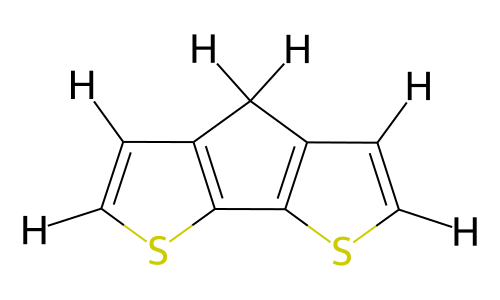

In [30]:
b= BondWalker(Molecule.from_file("/Users/madilyn/Projects/repos/forcefields/CPDT.sdf",file_format = "sdf"))
compound = b.fill_in_bonds()
compound.visualize()

In [19]:
#Change input file for molecule
#This one needs to be .sdf file!

molecule = compound

molecule_graph = esp.Graph(molecule)

espaloma_model = torch.load("espaloma_model.pt")
espaloma_model(molecule_graph.heterograph)
openmm_system = esp.graphs.deploy.openmm_system_from_graph(molecule_graph)

# Store the results for each in something more accessible
pair_forces = openmm_system.getForces()[1]
angle_forces = openmm_system.getForces()[3]
bond_forces = openmm_system.getForces()[2]
torsion_forces = openmm_system.getForces()[0]

In [5]:
# get a parmed structure from openmm 
import parmed as pmd
topology = molecule.to_topology()
openmm_topology = topology.to_openmm()

structure = pmd.openmm.load_topology(topology=openmm_topology, system=openmm_system)
structure.bonds.sort(key=lambda x: x.atom1.idx)

In [6]:
# step 1: how to get bond parameters

bond_parameters = {}

for bond in structure.bonds:
    bond_parameters[(bond.atom1.name, bond.atom2.name)] = {"k":[bond.type.k] , "l0":[bond.type.req]}
    
# step 2: get angle parameters

angle_parameters = {}

for angle in structure.angles:
    angle_parameters[(angle.atom1.name, angle.atom2.name,angle.atom3.name)] = {"k":[angle.type.k], 
                                                                               "t0":[angle.type.theteq]}
    
# step 3: dihedral parameters

dihedral_parameters = {}

for dihedral in structure.dihedrals:
    dihedral_parameters[(dihedral.atom1.name, dihedral.atom2.name,dihedral.atom3.name,
                         dihedral.atom4.name)] = {"periodicity":[dihedral.type.per],
                                                  "k":[dihedral.type.phi_k],"phase":[dihedral.type.phase]}
    
# step 4: non-bonding parameters

nonbonded_parameters = {}

for nonbonded in structure.adjusts:
    nonbonded_parameters[(nonbonded.atom1.name,nonbonded.atom2.name)] = {"sigma":[nonbonded.type.rmin],
                                                    "epsilon":[nonbonded.type.epsilon],
                                                    "charge":[nonbonded.type.chgscale]}

In [27]:
particle_types = []
particle_type_dict = dict()

for i in range(pair_forces.getNumParticles()):
    pair_parms = pair_forces.getParticleParameters(index=i)
    charge = pair_parms[0]
    sigma = pair_parms[1]
    epsilon = pair_parms[2]
    if (charge, sigma, epsilon) not in particle_types: 
        particle_types.append((charge, sigma, epsilon))
        print(i,(charge, sigma, epsilon))

    particle_type_dict[i] = particle_types.index((charge, sigma, epsilon))
type(particle_type_dict)

0 (Quantity(value=0.05519999999999999, unit=elementary charge), Quantity(value=0.3399669508423535, unit=nanometer), Quantity(value=0.4577296, unit=kilojoule/mole))
1 (Quantity(value=-0.1303, unit=elementary charge), Quantity(value=0.3399669508423535, unit=nanometer), Quantity(value=0.359824, unit=kilojoule/mole))
2 (Quantity(value=-0.07610000000000001, unit=elementary charge), Quantity(value=0.3399669508423535, unit=nanometer), Quantity(value=0.359824, unit=kilojoule/mole))
3 (Quantity(value=0.09019999999999999, unit=elementary charge), Quantity(value=0.35635948725613575, unit=nanometer), Quantity(value=1.046, unit=kilojoule/mole))
4 (Quantity(value=-0.1911, unit=elementary charge), Quantity(value=0.3399669508423535, unit=nanometer), Quantity(value=0.359824, unit=kilojoule/mole))
5 (Quantity(value=-0.12100000000000001, unit=elementary charge), Quantity(value=0.3399669508423535, unit=nanometer), Quantity(value=0.359824, unit=kilojoule/mole))
11 (Quantity(value=0.07569999999999999, unit=

dict

In [ ]:
compound.bonds

In [48]:
""" type map is where our error is coming from """


import networkx  as nx
Gopenmm = nx.Graph()
Gparmed = nx.Graph()
#openmm:
for i in range(bond_forces.getNumBonds()):
    Gopenmm.add_edge(bond_forces.getBondParameters(index=i)[0],bond_forces.getBondParameters(index=i)[1])
#parmed
for b in compound.bonds:
    Gparmed.add_edge(b.atom1_index,b.atom2_index)
type_map = {}
#nx.rooted_tree_isomorphism
#in here we still need to check that one known index on one corresponds to the same index on the other....
tree_openmm = nx.bfs_tree(Gopenmm,0)
tree_parmed = nx.bfs_tree(Gparmed,0)
if nx.is_isomorphic(Gopenmm,Gparmed):
#if nx.isomorphism.tree_isomorphism(tree_openmm,tree_parmed):  <- want this work
    for b in compound.bonds:
        type_map[b.atom1_index] = b.atom1.atomic_number.__str__()
        type_map[b.atom2_index] = b.atom2.atomic_number.__str__()
print(type_map)

{1: '6', 0: '6', 5: '6', 2: '6', 3: '16', 4: '6', 6: '6', 10: '16', 7: '6', 8: '6', 9: '6', 11: '1', 12: '1', 13: '1', 14: '1', 15: '1', 16: '1'}


In [9]:
# Rename the particle types so that they match the xml file
# This is needed when we aren't using SMARTS matching with Foyer.

CPDT = mb.load("/Users/madilyn/Projects/repos/forcefields/CPDT.mol2")

for index in type_map:
    CPDT[index].name = type_map[index]

In [10]:
bond_types = []
bond_dict = dict() 

for i in range(bond_forces.getNumBonds()):
    bond_parms = bond_forces.getBondParameters(index=i)
    l0 = bond_parms[2]/bond_parms[2].unit
    k = bond_parms[3]/bond_parms[3].unit
    bond_dict[type_map[bond_parms[0]],type_map[bond_parms[1]]] = {'k':k,'l0':l0}
print(bond_dict)

{('C1', 'C2'): {'k': 62091.06678567673, 'l0': 0.16370454794869382}, ('C1', 'H1'): {'k': 89975.28480830675, 'l0': 0.12312252469607743}, ('C2', 'C2'): {'k': 88798.93430297787, 'l0': 0.15396536501212987}, ('C2', 'S1'): {'k': 16832.675435212892, 'l0': 0.2090723255760851}, ('S1', 'C2'): {'k': 16832.671942444256, 'l0': 0.20907235080922085}, ('C2', 'H2'): {'k': 234207.9082105277, 'l0': 0.1035506322053171}, ('C2', 'H3'): {'k': 67288.62086433225, 'l0': 0.12226254158024269}}


In [11]:
angle_types = []
angle_dict = dict()

for i in range(angle_forces.getNumAngles()):
    angle_parms = angle_forces.getAngleParameters(index=i)
    k = angle_parms[4]/angle_parms[4].unit
    t0 = angle_parms[3]/angle_parms[3].unit  
    angle_dict[type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]]] = {'k':k,'t0':t0}
print(angle_dict)

{('C1', 'C2', 'C2'): {'k': 428.2723659791133, 't0': 2.2276835441589355}, ('C2', 'C1', 'C2'): {'k': 615.1940862008681, 't0': 2.1875998973846436}, ('C2', 'C1', 'H1'): {'k': 542.707708350176, 't0': 2.2062010765075684}, ('C2', 'C2', 'S1'): {'k': 489.7428043484336, 't0': 2.2854721546173096}, ('C2', 'C2', 'C2'): {'k': 538.6140739418067, 't0': 2.1330296993255615}, ('C2', 'C2', 'H3'): {'k': 475.47386621663804, 't0': 2.293156385421753}, ('C2', 'S1', 'C2'): {'k': 433.8852635879432, 't0': 1.7351198196411133}, ('S1', 'C2', 'C2'): {'k': 489.7427261024469, 't0': 2.2854723930358887}, ('S1', 'C2', 'H2'): {'k': 546.9487190744655, 't0': 2.3533806800842285}, ('C2', 'C2', 'H2'): {'k': 593.7405624487033, 't0': 2.430001735687256}, ('H1', 'C1', 'H1'): {'k': 482.2260645145884, 't0': 2.1558918952941895}}


In [12]:
dihedral_types = []
dihedral_dict = {}

for i in range(torsion_forces.getNumTorsions()):
    if i%6==0:
        periodicity=[]
        phase = []
        k = []
    dihedral_parms = torsion_forces.getTorsionParameters(index=i)
    periodicity.append(dihedral_parms[4])  
    phase.append( dihedral_parms[5]/dihedral_parms[5].unit)
    k.append(dihedral_parms[6]/dihedral_parms[6].unit)
    dt = (type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],
                  type_map[dihedral_parms[3]])
   

    if periodicity[-1]==6:
        #print(dt,periodicity,phase)
        dihedral_dict[dt] = {'periodicity':periodicity,'k':k,'phase':phase}
print(dihedral_dict)

{('C1', 'C2', 'C2', 'S1'): {'periodicity': [1, 2, 3, 4, 5, 6], 'k': [3.3956337485884065, 5.358274164816488, 0.3514027262003391, 0.5797049538492011, 2.1823294723739326, 0.10449751521722397], 'phase': [0.0, 3.141592653589793, 3.141592653589793, 0.0, 0.0, 3.141592653589793]}, ('C1', 'C2', 'C2', 'C2'): {'periodicity': [1, 2, 3, 4, 5, 6], 'k': [0.2331705951328917, 0.0660102705167582, 0.5101088164739147, 0.9238748166553866, 1.192967655237741, 0.2470372510856453], 'phase': [3.141592653589793, 0.0, 0.0, 0.0, 3.141592653589793, 3.141592653589793]}, ('C1', 'C2', 'C2', 'H3'): {'periodicity': [1, 2, 3, 4, 5, 6], 'k': [0.09253321481573865, 3.5598097223686493, 0.27324476625080363, 0.6732871539239296, 0.558216649755955, 0.02489322710756619], 'phase': [3.141592653589793, 3.141592653589793, 0.0, 3.141592653589793, 0.0, 0.0]}, ('C2', 'C1', 'C2', 'C2'): {'periodicity': [1, 2, 3, 4, 5, 6], 'k': [2.42909775288035, 3.088103791640806, 0.12707148237571825, 0.3429130366450648, 0.585680991082234, 0.015177276229

In [17]:
nonbonded_types = []
nonbonded_dict = {}

for i in range(pair_forces.getNumParticles()):
    nonbonded_parms = pair_forces.getParticleParameters(index=i)
    charge = nonbonded_parms[0]/nonbonded_parms[0].unit
    sigma = nonbonded_parms[1]/nonbonded_parms[1].unit
    epsilon = nonbonded_parms[2]/nonbonded_parms[2].unit
    #if (charge,sigma,epsilon) not in nonbonded_types:
    nonbonded_types.append((charge,sigma,epsilon))
    nonbonded_dict[(type_map[i])]={'charge':charge,'sigma':sigma,'epsilon':epsilon}
print(nonbonded_dict)

{'C1': {'charge': 0.05519999999999999, 'sigma': 0.3399669508423535, 'epsilon': 0.4577296}, 'C2': {'charge': -0.1911, 'sigma': 0.3399669508423535, 'epsilon': 0.359824}, 'S1': {'charge': 0.09019999999999999, 'sigma': 0.35635948725613575, 'epsilon': 1.046}, 'H1': {'charge': 0.07569999999999999, 'sigma': 0.2649532787749369, 'epsilon': 0.06568879999999999}, 'H2': {'charge': 0.17, 'sigma': 0.2510552587719476, 'epsilon': 0.06276}, 'H3': {'charge': 0.155, 'sigma': 0.25996424595335105, 'epsilon': 0.06276}}


In [25]:
# Save the forcefield XML file for future use, so that we don't have to repeat the espaloma process everytime
mbuild_to_foyer_xml(
    file_name="CPDT.xml", #change this to whatever you want to save your xml file as
    compound=compound,
    bond_params=bond_dict,
    angle_params=angle_dict,
    dihedral_params=dihedral_dict,
    dihedral_type="periodic",
    non_bonded_params=nonbonded_dict,
    combining_rule="geometric",
    name="",
    version="",
    coulomb14scale=1.0,
    lj14scale=1.0)

# Save the mb.Compound with the new atom type names for future use.
CPDT.save("/Users/madilyn/Projects/repos/forcefields/CPDT_typed.mol2", overwrite=True) #change this to match your molecule name. 

TypeError: 'list' object is not callable

In [35]:
compound.atoms

[Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=16),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=6),
 Atom(name=, atomic number=16),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1),
 Atom(name=, atomic number=1)]

In [29]:
CPDT.particles

<bound method Compound.particles of <Compound 17 particles, 19 bonds, non-periodic, id: 6526385360>>

In [32]:
part_types = tuple(set(p.name for p in CPDT.particles()))

In [42]:
type(part_types)

tuple

In [41]:
part_types = tuple(p.name for p in CPDT.particles())

In [43]:
part_types

('C1',
 'C2',
 'C2',
 'S1',
 'C2',
 'C2',
 'C2',
 'C2',
 'C2',
 'C2',
 'S1',
 'H1',
 'H1',
 'H2',
 'H3',
 'H3',
 'H2')

In [44]:
type_map

{1: 'C2',
 0: 'C1',
 5: 'C2',
 2: 'C2',
 3: 'S1',
 4: 'C2',
 6: 'C2',
 10: 'S1',
 7: 'C2',
 8: 'C2',
 9: 'C2',
 11: 'H1',
 12: 'H1',
 13: 'H2',
 14: 'H3',
 15: 'H3',
 16: 'H2'}